In [56]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 9)

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# from wordcloud import STOPWORDS

In [57]:

import nltk
nltk.download()
# https://www.nltk.org/data.html
# A new window should open, showing the NLTK Downloader. Click on the File menu and select Change Download Directory. 
# For central installation, set this to C:\nltk_data (Windows), /usr/local/share/nltk_data (Mac), or /usr/share/nltk_data (Unix). 
# Next, select the packages or collections you want to download.
# If you did not install the data to one of the above central locations, you will need to set the NLTK_DATA environment variable 
# to specify the location of the data. (On a Windows machine, right click on “My Computer” then 
# select Properties > Advanced > Environment Variables > User Variables > New...)
# Test that the data has been installed as follows. (This assumes you downloaded the Brown Corpus):

# then close the window to continue

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [58]:
alexa = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Sentiment_analysis_on_amazon_alexa_reviews_amazon_alexa.tsv', delimiter = '\t', quoting = 3)

alexa.shape

(3150, 5)

In [59]:
alexa.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [60]:
alexa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [61]:
alexa.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [62]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    print("| Feature  | Data Type|")
    print("|-----|------|")
    for col in data.columns:
        description = ''
        col_dropna = data[col].dropna()
        example = col_dropna.sample(1).values[0]
        if type(example) == str:
            description = 'str '
            if len(col_dropna.unique()) < 10:
                description += '{'
                description += '; '.join([ f'"{name}"' for name in col_dropna.unique()])
                description += '}'
            else:
                description += '[ example: "'+ example + '" ]'
        elif (type(example) == np.int32) and (len(col_dropna.unique()) < 10) :
            description += 'dummy int32 {'
            description += '; '.join([ f'{name}' for name in sorted(col_dropna.unique())])
            description += '}'
        else:
            try:
                description = example.dtype
            except:
                 description = type(example)
        print("|" + col.ljust(longestColumnName)+ f'|   {description}  |')
 
attribute_description(alexa)

| Feature  | Data Type|
|-----|------|
|rating          |   int64  |
|date            |   str [ example: "30-Jul-18" ]  |
|variation       |   str [ example: "Configuration: Fire TV Stick" ]  |
|verified_reviews|   str [ example: "Works as advertised. Very easy to setup. Still learning what this can do." ]  |
|feedback        |   int64  |


In [63]:
# Es wird überprüft, ob es "null data" gibt oder nicht --> es geht hervor, dass es keine "null data" gibt

alexa.isnull().any().any()


# ## Beschreibung der Daten entsprechend der Länge der Bewertungen

False

In [64]:
#Es wird eine Längenkolonne zur Analyse der Länge der Bewertungen hinzugefügt

alexa['length'] = alexa['verified_reviews'].apply(len)
alexa.groupby('length').describe().sample(20)

rating                                               feedback  \
        count      mean       std  min   25%  50%  75%  max    count   
length                                                                 
50       21.0  4.904762  0.300793  4.0  5.00  5.0  5.0  5.0     21.0   
467       1.0  5.000000       NaN  5.0  5.00  5.0  5.0  5.0      1.0   
313       2.0  5.000000  0.000000  5.0  5.00  5.0  5.0  5.0      2.0   
8        41.0  4.853659  0.357839  4.0  5.00  5.0  5.0  5.0     41.0   
142       6.0  4.333333  1.632993  1.0  5.00  5.0  5.0  5.0      6.0   
595       1.0  5.000000       NaN  5.0  5.00  5.0  5.0  5.0      1.0   
204       4.0  4.750000  0.500000  4.0  4.75  5.0  5.0  5.0      4.0   
325       2.0  5.000000  0.000000  5.0  5.00  5.0  5.0  5.0      2.0   
116      14.0  4.142857  1.561909  1.0  4.25  5.0  5.0  5.0     14.0   
1566      1.0  5.000000       NaN  5.0  5.00  5.0  5.0  5.0      1.0   
1311      1.0  3.000000       NaN  3.0  3.00  3.0  3.0  3.0      1.0   
12       36.0  4.944444  0.232311  4.0  5.00  5.0  5.0  5.0     36.0   
160       5.0  5.000000  0.000000  5.0  5.00  5.0  5.0  5.0      5.0   
103      12.0  4.583333  0.668558  3.0  4.00  5.0  5.0  5.0     12.0   
41       11.0  4.454545  1.293340  1.0  5.00  5.0  5.0  5.0     11.0   
632       1.0  4.000000       NaN  4.0  4.00  4.0  4.0  4.0      1.0   
166       4.0  4.000000  2.000000  1.0  4.00  5.0  5.0  5.0      4.0   
170       8.0  5.000000  0.000000  5.0  5.00  5.0  5.0  5.0      8.0   
324       1.0  2.000000       NaN  2.0  2.00  2.0  2.0  2.0      1.0   
112       7.0  4.714286  0.487950  4.0  4.50  5.0  5.0  5.0      7.0   

                                                      
            mean       std  min   25%  50%  75%  max  
length                                                
50      1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
467     1.000000       NaN  1.0  1.00  1.0  1.0  1.0  
313     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
8       1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
142     0.833333  0.408248  0.0  1.00  1.0  1.0  1.0  
595     1.000000       NaN  1.0  1.00  1.0  1.0  1.0  
204     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
325     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
116     0.785714  0.425815  0.0  1.00  1.0  1.0  1.0  
1566    1.000000       NaN  1.0  1.00  1.0  1.0  1.0  
1311    1.000000       NaN  1.0  1.00  1.0  1.0  1.0  
12      1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
160     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
103     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
41      0.909091  0.301511  0.0  1.00  1.0  1.0  1.0  
632     1.000000       NaN  1.0  1.00  1.0  1.0  1.0  
166     0.750000  0.500000  0.0  0.75  1.0  1.0  1.0  
170     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
324     0.000000       NaN  0.0  0.00  0.0  0.0  0.0  
112     1.000000  0.000000  1.0  1.00  1.0  1.0  1.0

Text(0.5, 1.0, 'Verteilung nach Länge')

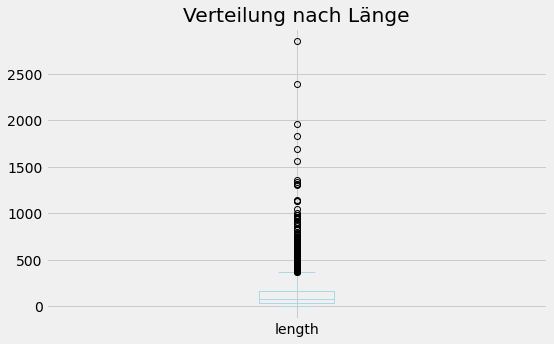

In [65]:
#veranschaulicht die Verteilung nach Länge

plt.figure(figsize=(8,5))
alexa.length.plot(color = 'lightblue',kind="box")
plt.title("Verteilung nach Länge")

Text(0.5, 1.0, 'Durschnittliche Wortlänge von positiven und negativen Bewertungen')

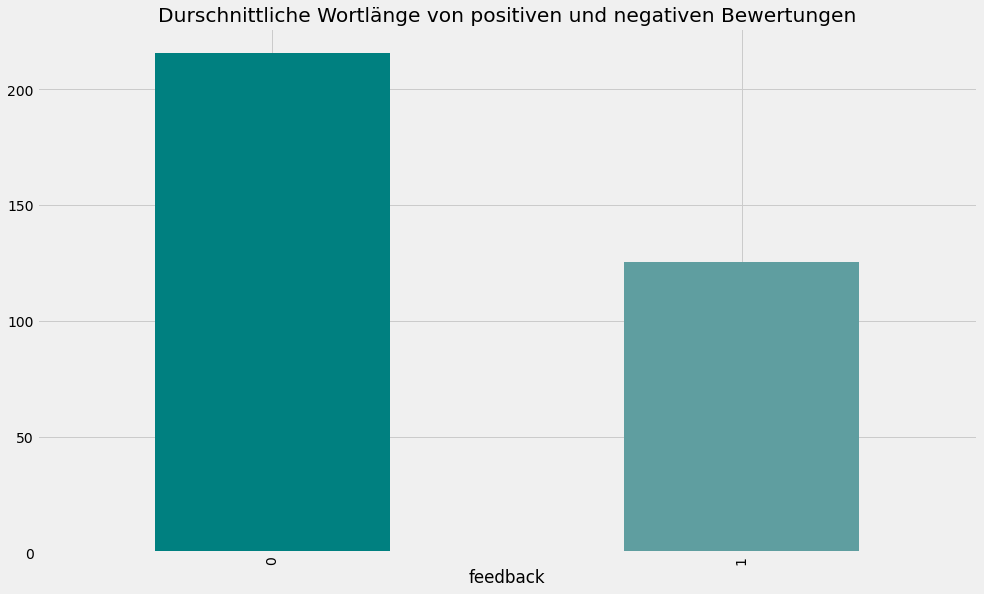

In [66]:
#veranschaulicht die Durschnittliche Wortlänge von positiven und negativen Bewertungen 

colors = ['teal', 'cadetblue']
alexa.groupby("feedback").length.mean().plot(color = colors, kind="bar")
plt.title("Durschnittliche Wortlänge von positiven und negativen Bewertungen")

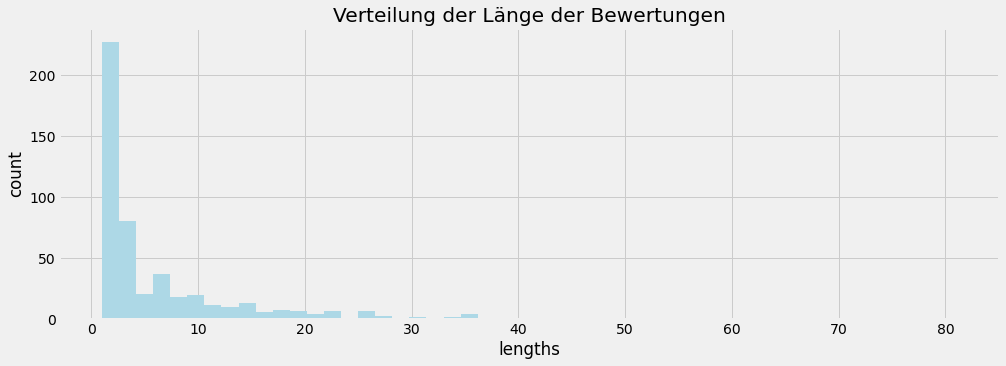

In [67]:
alexa['length'].value_counts().plot.hist(color = 'lightblue', figsize = (15, 5), bins = 50)
plt.title('Verteilung der Länge der Bewertungen')
plt.xlabel('lengths')
plt.ylabel('count')
plt.show()

In [68]:
#zeigt ein paar Beispiele von verschiedenen Bewertungen mit verschiedenen Längen

alexa[alexa['length'] == 13]['verified_reviews'].iloc[0]

'Love my Echo!'

In [69]:
alexa[alexa['length'] == 27]['verified_reviews'].iloc[0]

'"I love it, wife hates it."'

In [70]:
alexa[alexa['length'] == 45]['verified_reviews'].iloc[0]

'Super easy set up and am loving our new Echo!'

In [71]:
alexa[alexa['length'] == 270]['verified_reviews'].iloc[0]


# ## Beschreibung der Daten entsprechend den Bewertungen

'"Love the Echo !!! I love the size, material and speaker quality. I have it hooked up to one light easily and will work on additional lights and thermostat. Next is Echo Dot for bedroom. There is a lot more to do with Echo that you think. Traffic, Weather, Trivia, etc."'

In [72]:
#zeigt die Verteilung der Sterne-Bewertungen an --> es geht hervor, dass am häufigsten 5 Sterne vergeben werden

alexa.groupby('rating').describe()

feedback                                     length              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.658385   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  250.020833   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  208.098684   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  179.338462   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  109.006562   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.928219  1.0  36.00  120.0  284.00  1126.0  
2       270.179472  1.0  78.75  165.0  311.25  1688.0  
3       272.582517  1.0  54.00  131.0  286.00  1956.0  
4       216.415268  1.0  34.50  100.0  242.00  1362.0  
5       152.505019  1.0  27.00   65.0  136.00  2853.0

In [73]:
#zeigt in welche Richtung (positiv/negativ) die Bewertungen gehen --> es geht hervor, dass die Bewertungen eher positiv ausfallen

alexa.feedback.value_counts()


# ## Verteilung der positiven und negativen Bewertungen
# 

1    2893
0     257
Name: feedback, dtype: int64

Text(0.5, 1.0, 'Prozentuale Verteilung von positiven und negativen Bewertungen')

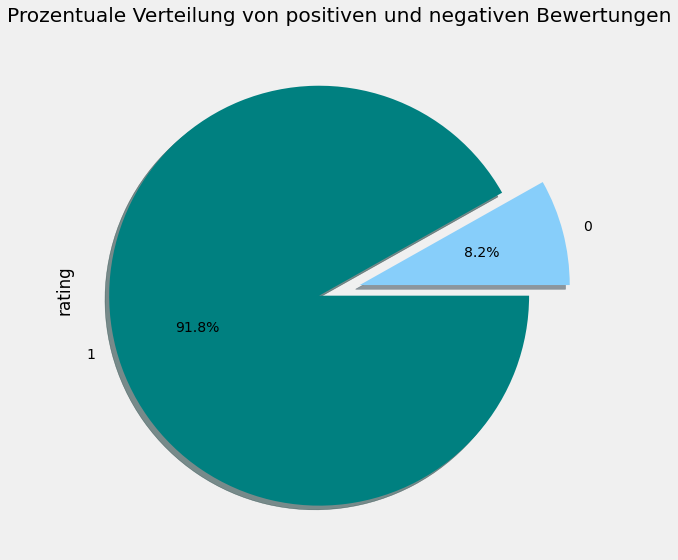

In [74]:
#zeigt diprozentuale Verteilung von positiven und negativen Bewertungen an --> es geht hervor, dass Alexa sehr gut abschneidet
 
colors = ['lightskyblue', 'teal']
alexa.groupby("feedback").rating.count().plot(colors=colors,kind="pie",shadow=True, autopct='%1.1f%%',explode=(0.1,0.1))
plt.title("Prozentuale Verteilung von positiven und negativen Bewertungen")

In [75]:
print("Percentage of negative reviews: ", (len(alexa[alexa['feedback'] == 0]) * 100)/len(alexa))
print("Percentage of Positive reviews: ", (len(alexa[alexa['feedback'] == 1]) * 100)/len(alexa))

Percentage of negative reviews:  8.158730158730158
Percentage of Positive reviews:  91.84126984126983


Text(0.5, 1.0, 'Prozentuale Verteilung nach Anzahl der Sterne')

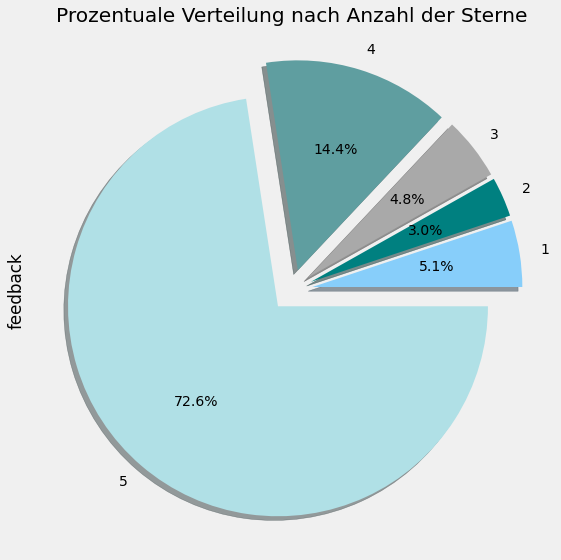

In [76]:
#visualisiert die prozentuale Verteilung nach Anzahl der Sterne

colors = ['lightskyblue', 'teal', 'darkgrey', 'cadetblue', 'powderblue']
alexa.groupby("rating").feedback.count().plot(colors=colors,kind="pie",shadow=True,autopct='%1.1f%%',explode=(0.1,0.1,0.1,0.1,0.1))
plt.title("Prozentuale Verteilung nach Anzahl der Sterne")


# ## Rating vs. Länge
# 
# 

Text(0.5, 1.0, 'Rating vs. Länge')

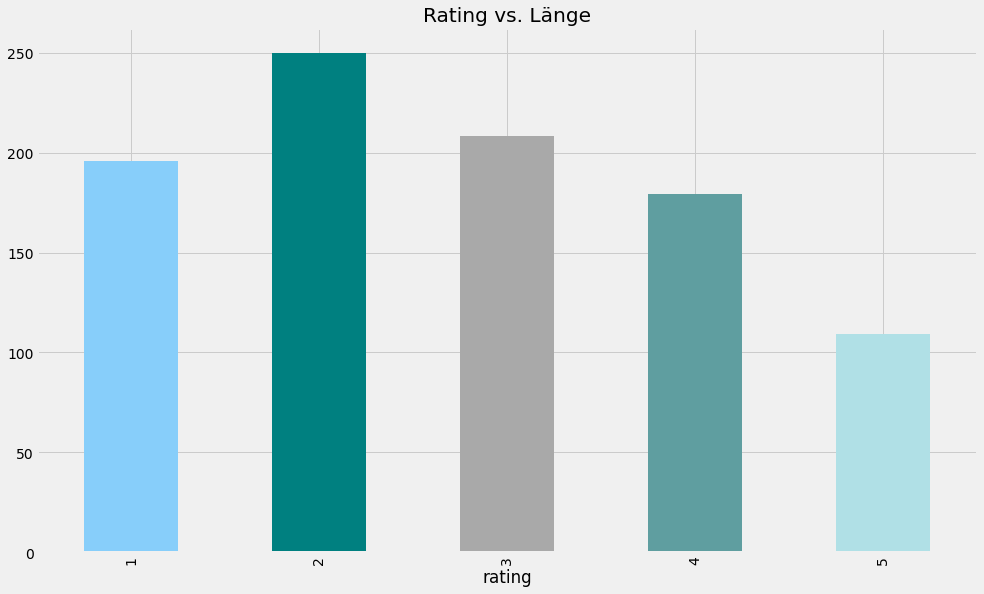

In [77]:
#veranschaulicht die Verteilung der Bewertungen nach Sternevergabe und Länge

colors = ['lightskyblue', 'teal', 'darkgrey', 'cadetblue', 'powderblue']
alexa.groupby("rating").length.mean().plot(color= colors,kind="bar")
plt.title("Rating vs. Länge")


# ## Variation vs. Rating 

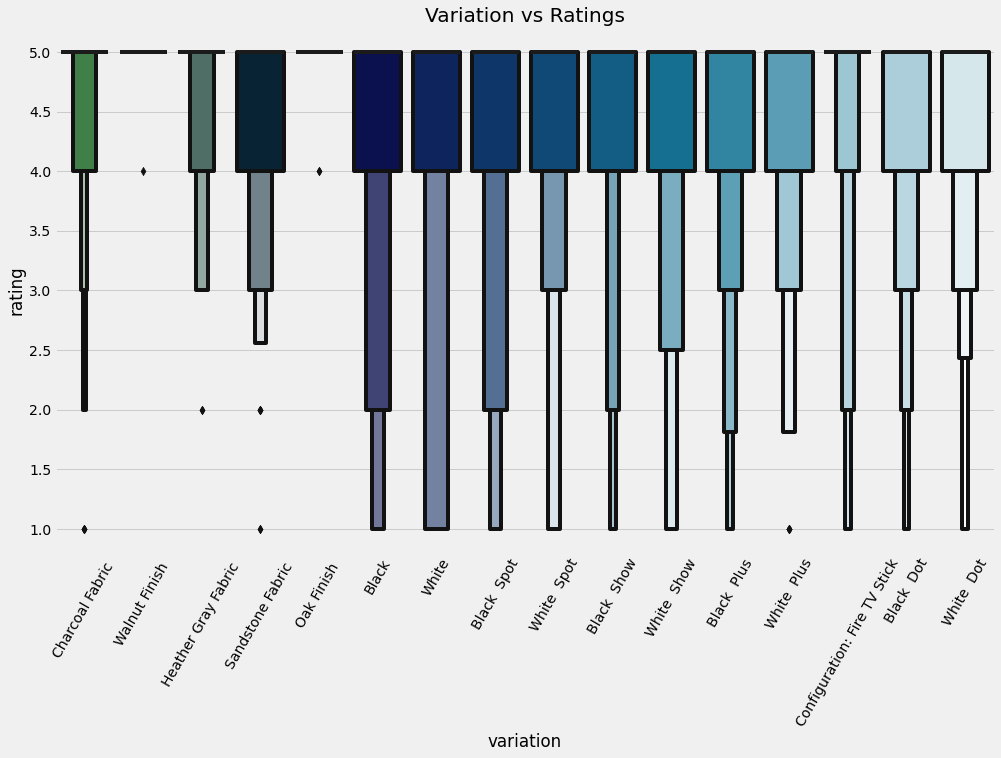

In [78]:
plt.rcParams['figure.figsize'] = (15, 9)

sns.boxenplot(alexa['variation'], alexa['rating'], palette = 'ocean')
plt.title("Variation vs Ratings")
plt.xticks(rotation = 60)
plt.show()


# ## Variation vs. Länge 

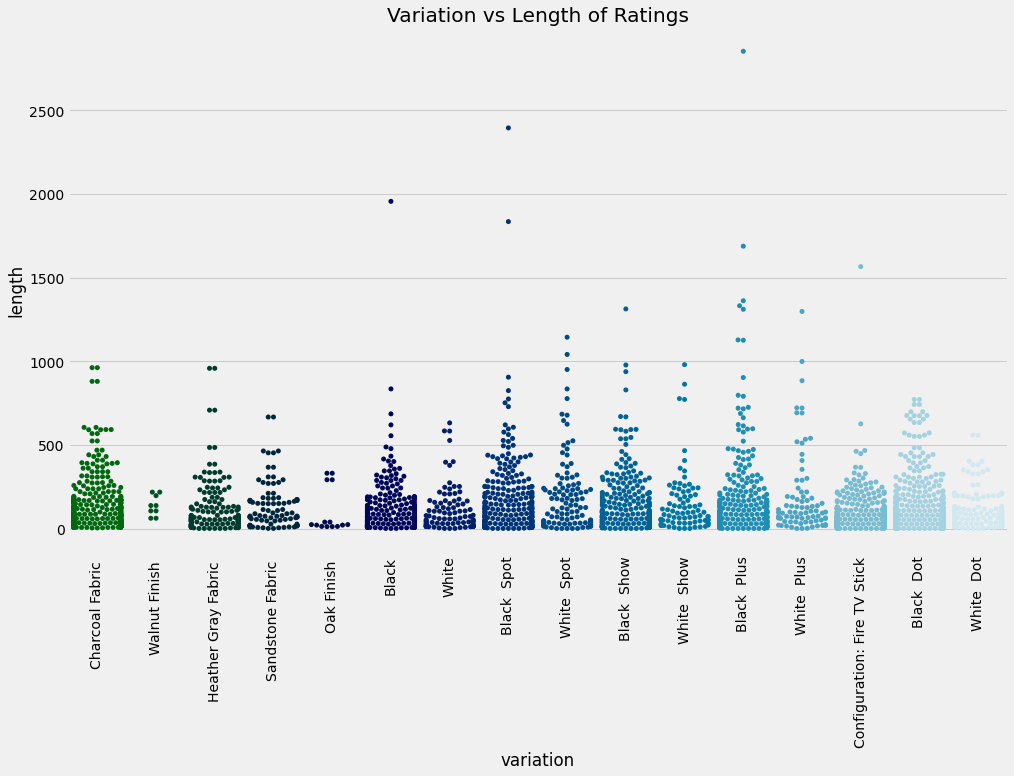

In [79]:
sns.swarmplot(alexa['variation'], alexa['length'], palette = 'ocean')
plt.title("Variation vs Length of Ratings")
plt.xticks(rotation = 90)
plt.show()


# ## Feedback vs. Länge
# 

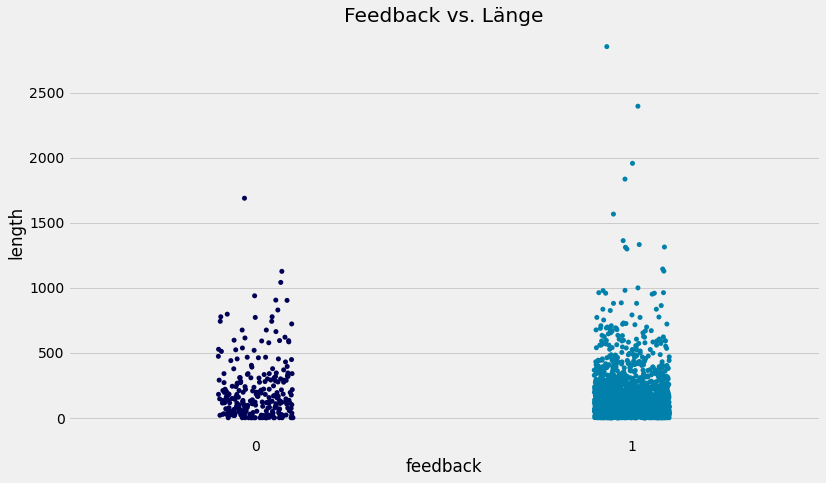

In [80]:

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 7)

sns.stripplot(alexa['feedback'], alexa['length'], palette = 'ocean')
plt.title("Feedback vs. Länge")
plt.show()

In [81]:
sum(alexa['feedback'] == 1)

2893

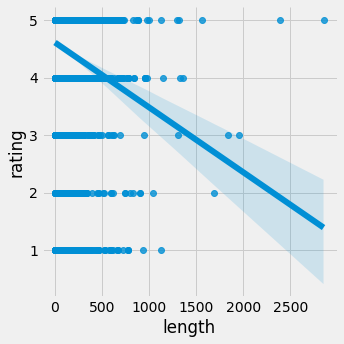

In [82]:
sns.lmplot(x='length',y='rating',data=alexa)

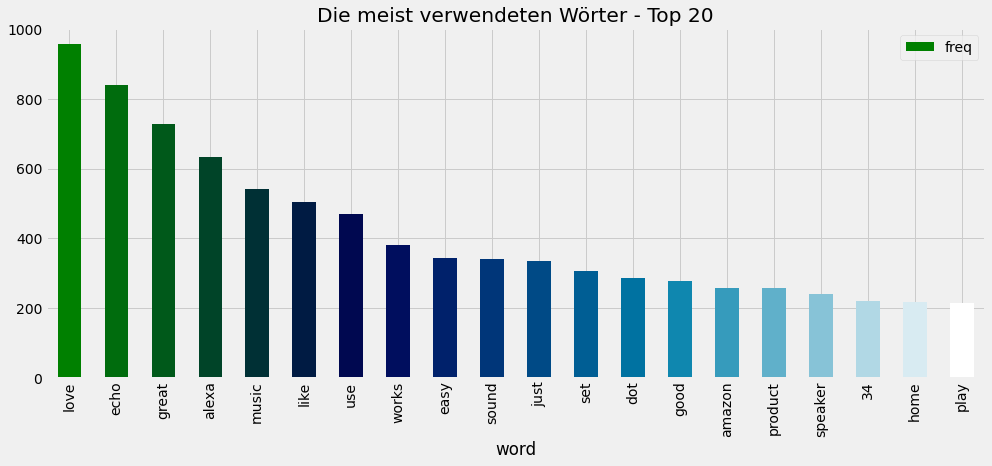

In [83]:
# CountVectorizer zeigt die am häufigsten verwendeten Wörter

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(alexa.verified_reviews)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color=color)
plt.title("Die meist verwendeten Wörter - Top 20")
plt.show()

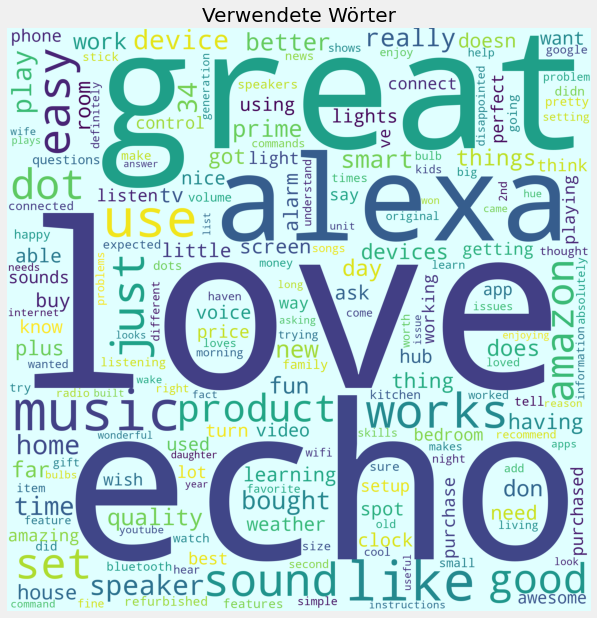

In [84]:
#Visualisiert die meist verwendeten Wörter

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Verwendete Wörter", fontsize = 20)
plt.show()

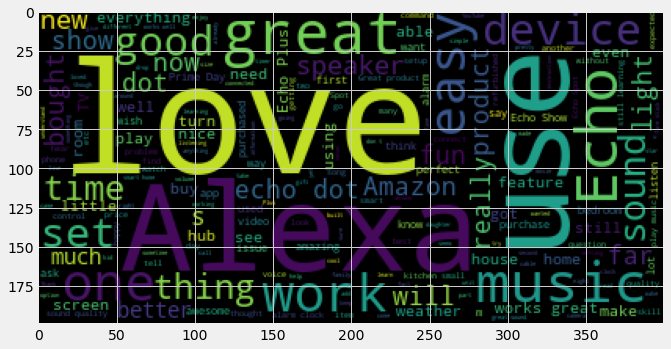

In [85]:
#visualisiert positive Bewertungen
good=alexa[alexa.feedback==1].verified_reviews.unique().tolist()
good=" ".join(good)
cv=WordCloud().generate(good)
cv
plt.figure(figsize=(10,8))
plt.imshow(cv)

In [86]:
alexa

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


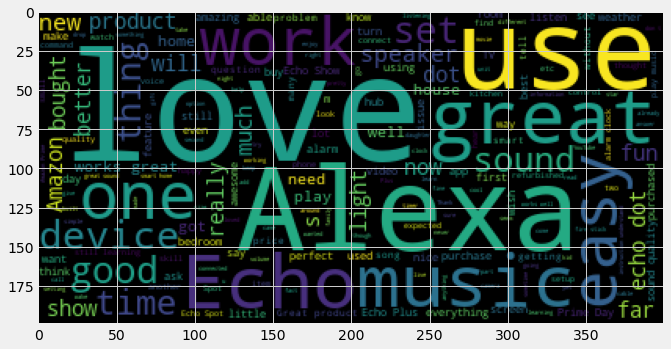

In [87]:
#visualisiert positive Bewertungen
good=alexa[alexa.feedback==1].verified_reviews.unique().tolist()
good=" ".join(good)
cv=WordCloud().generate(good)
cv
plt.figure(figsize=(10,8))
plt.imshow(cv)

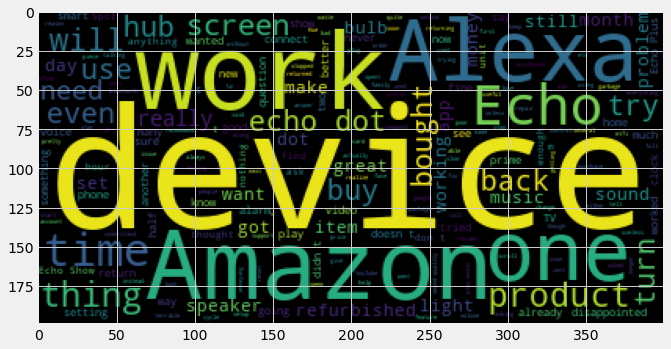

In [88]:
#visualisiert negative Bewertunegen
bad=alexa[alexa.feedback==0].verified_reviews.unique().tolist()
bad=" ".join(bad)
cv=WordCloud().generate(bad)
cv
plt.figure(figsize=(10,8))
plt.imshow(cv)


# # Meachine Learning Model Teil

In [89]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [90]:
corpus = []
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
for i in range(0, len(alexa)):
    review = re.sub('[^a-zA-Z]', ' ', alexa['verified_reviews'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

In [91]:
corpus

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad not see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons not seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constantli',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come not get around fast like enjoy littl b

In [92]:
counter = CountVectorizer(max_features = 2500)
X = counter.fit_transform(corpus).toarray()
y = alexa.iloc[:, 4].values

In [93]:
counter.get_feature_names()

['abay',
 'abc',
 'abd',
 'abil',
 'abl',
 'abod',
 'absolut',
 'absolutli',
 'ac',
 'accent',
 'accept',
 'access',
 'accessori',
 'accesss',
 'accid',
 'accident',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accur',
 'accuraci',
 'accustom',
 'acknowledg',
 'acoust',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'adapt',
 'add',
 'addict',
 'addit',
 'addon',
 'address',
 'adept',
 'adequ',
 'adjac',
 'adjust',
 'admit',
 'adopt',
 'ador',
 'adult',
 'advanc',
 'advantag',
 'advertis',
 'advic',
 'advis',
 'aesthet',
 'af',
 'affirm',
 'afford',
 'afraid',
 'afternoon',
 'afterward',
 'age',
 'agent',
 'ago',
 'agre',
 'agreement',
 'ahead',
 'ai',
 'aid',
 'aint',
 'air',
 'aka',
 'al',
 'alabama',
 'alarm',
 'albeit',
 'alcohol',
 'alert',
 'alex',
 'alexa',
 'alexi',
 'alexia',
 'alexu',
 'algo',
 'aliv',
 'allevi',
 'allow',
 'allrecip',
 'almost',
 'alon',
 'along',
 'alongsid',
 'alot',
 'aloud',
 'alread',
 'alreadi',
 'alright',
 'also',

In [94]:
sum(sum(X == 4))

127

In [95]:
alexa[alexa['feedback']==0].head(20)

,rating,date,variation,verified_reviews,feedback,length
46,2,30-Jul-18,Charcoal Fabric,"""It's like Siri, in fact, Siri answers more ac...",0,165
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0,53
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0,18
162,1,30-Jul-18,Sandstone Fabric,"""Stopped working after 2 weeks ,didn't follow ...",0,89
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0,20
187,2,29-Jul-18,Charcoal Fabric,"""Really disappointed Alexa has to be plug-in t...",0,340
205,2,29-Jul-18,Sandstone Fabric,It's got great sound and bass but it doesn't w...,0,114
233,2,29-Jul-18,Sandstone Fabric,"""I am not super impressed with Alexa. When my ...",0,309
299,2,29-Jul-18,Charcoal Fabric,Too difficult to set up. It keeps timing out ...,0,79
341,1,28-Jul-18,Charcoal Fabric,Alexa hardly came on..,0,22


In [96]:
#Daten werden in Test und Train Daten aufgeteilt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_preddata = classifier.predict(X_test)

In [103]:
print("The F1 score is: ", f1_score(y_test, y_preddata, average="macro")*100)
print("The precision score is: ", precision_score(y_test, y_preddata, average="macro")*(100))
print("The recall score is: ", recall_score(y_test, y_preddata, average="macro")*100) 
print("The accuracy score is: ", accuracy_score(y_test, y_preddata)*100)


# ## Decision tree (2. Variante)
# 
# 

The F1 score is:  73.798908703753
The precision score is:  74.67241379310346
The recall score is:  73.00347222222221
The accuracy score is:  92.06349206349206


In [98]:
dt_clf = DecisionTreeClassifier(class_weight='balanced')

In [99]:
dt_clf.fit(X_train, y_train)               # Model fitting auf X_train,y_train
y_pred = dt_clf.predict(X_test)

In [100]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[ 30  24]
 [ 46 530]]


In [101]:
cr = classification_report(y_test ,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.39      0.56      0.46        54
           1       0.96      0.92      0.94       576

    accuracy                           0.89       630
   macro avg       0.68      0.74      0.70       630
weighted avg       0.91      0.89      0.90       630



In [102]:
acc=accuracy_score(y_test,y_pred)
print(acc)

0.8888888888888888
